Experiment: Exploratory Data Analysis and Baseline Modeling on GOES SEP Dataset

Objective:
To perform exploratory data analysis (EDA) on the GOES SEP dataset, followed by training a baseline Random Forest classifier using stratified k-fold cross-validation. The model is evaluated on both training and validation sets. Feature importance is visualized to identify key predictors. A DiCE explainer is then created using both genetic and random generation methods for counterfactual explanations. All trained models and explainers are saved using pickle for reproducibility and future use.

In [6]:
import wandb
import matplotlib.pyplot as plt
import dice_ml
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns
import joblib
import os
from sklearn.preprocessing import MinMaxScaler
from scripts.SEP_CFE_functions import *

min_max_scaler = MinMaxScaler()
warnings.filterwarnings("ignore")

In [7]:
wandb.init(
    entity="gsu-dmlab",
    project="SEPCFE",  # You choose the project name
    name="Exp1_EDA_ModelTraining",  # Give each run a name
)


In [8]:
abt_path_train = '../data/raw/mean_sliced/train_data.csv'
df_train = pd.read_csv(abt_path_train,  sep=',',index_col=0)
df_train["Event_Y_N"] = df_train['Label'].replace({0:1, -1:0})
X_train = df_train.drop(["Label","Event_Y_N"],axis=1)
Y_train=df_train["Event_Y_N"]
abt_path_test = '../data/raw/mean_sliced/test_data.csv'
df_test = pd.read_csv(abt_path_test, sep=',',index_col=0)
df_test["Event_Y_N"] = df_test['Label'].replace({0:1, -1:0})
X_test = df_test.drop(["Label","Event_Y_N"],axis=1)
Y_test=df_test["Event_Y_N"]
abt_path_val = '../data/raw/mean_sliced/valid_data.csv'
df_val = pd.read_csv(abt_path_val, sep=',',index_col=0)
df_val["Event_Y_N"] = df_val['Label'].replace({0:1, -1:0})
X_val = df_val.drop(["Label","Event_Y_N"],axis=1)
Y_val=df_val["Event_Y_N"]

In [9]:
X_train.to_csv('../data/processed/X_train.csv')
Y_train.to_csv('../data/processed/Y_train.csv')
X_test.to_csv('../data/processed/X_test.csv')
Y_test.to_csv('../data/processed/Y_test.csv')
X_val.to_csv('../data/processed/X_val.csv')
Y_val.to_csv('../data/processed/Y_val.csv')

In [10]:
df_combined  = pd.DataFrame()
df_combined = pd.concat([df_combined,df_train], ignore_index=True)
df_combined = pd.concat([df_combined,df_val], ignore_index=True)
df_combined = pd.concat([df_combined,df_test], ignore_index=True)
df_multi_labels = pd.read_excel("../data/raw/multi_labels.xlsx",header=0)
df_multi_labels = df_multi_labels[df_multi_labels['File'] != '1991-06-18_23-16.csv']
df_multi_labels.rename(columns={'Label': 'Multi_Label'}, inplace=True)
# print(df_multi_labels)
# print(df_combined)
df_combined_labels= pd.concat([df_combined,df_multi_labels], axis=1 )
df_combined_labels.to_csv('../data/processed/df_combined_labels.csv')

In [11]:
df_combined_labels.shape

(2893, 932)

In [12]:

ts_directory_path = '../data/raw/data/'
all_items = os.listdir(ts_directory_path)
file_list = [f for f in all_items if os.path.isfile(os.path.join(ts_directory_path, f))]
print(f"\nTotal number of files: {len(file_list)}")
missing_in_list = df_multi_labels[~df_multi_labels['File'].isin(file_list)]
print(f"Total missing files:{missing_in_list.shape[0]} \nMissing timeseries files from Multi_Label.csv:")
print(missing_in_list)


Total number of files: 2894
Total missing files:0 
Missing timeseries files from Multi_Label.csv:
Empty DataFrame
Columns: [File, Multi_Label]
Index: []


Random Forest Classifier Training and Hyper Parameter Tuning on Training Dataset

In [13]:
# # Setup config
# config = wandb.config
# config.n_estimators = [50, 100, 200, 300, 400, 500]
# config.max_depth = [2, 3, 4, 5, 6, 7, 8]
# config.cv_splits = 5
# config.random_state = 42

In [14]:
# pipeline = Pipeline([
#     ("classifier", RandomForestClassifier(
#         random_state=config.random_state,
#         class_weight="balanced"
#     ))
# ])
# # Define hyperparameter grid using pipeline syntax
# param_grid = {
#     "classifier__n_estimators": config.n_estimators,
#     "classifier__max_depth": config.max_depth
# }
# # Scorer focused on F1 score for positive class (1)
# scorer = make_scorer(f1_score, pos_label=1)
#
# # Cross-validation strategy
# cv = StratifiedKFold(n_splits=config.cv_splits, shuffle=True, random_state=config.random_state)
#
# # Run GridSearchCV
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring=scorer,
#     cv=cv,
#     n_jobs=-1,
#     verbose=1
# )
#
# grid_search.fit(X_train, Y_train)
# best_model = grid_search.best_estimator_
# Y_pred = best_model.predict(X_train)
#
# # Log best params and score to wandb
# wandb.log({
#     "best_f1_cv": grid_search.best_score_,
#     "best_params": grid_search.best_params_,
#     "classification_report": classification_report(Y_train, Y_pred, output_dict=True),
#     "confusion_matrix": wandb.plot.confusion_matrix(
#         probs=None,
#         y_true=Y_train,
#         preds=Y_pred,
#         class_names=["Non-SEP", "SEP"]
#     )
# })
# # Log top 15 feature importances
# importances = best_model.named_steps["classifier"].feature_importances_
# feature_df = pd.DataFrame({
#     "Feature": X_train.columns,
#     "Importance": importances
# }).sort_values(by="Importance", ascending=False)
#
# plt.figure(figsize=(10, 6))
# sns.barplot(x="Importance", y="Feature", data=feature_df.head(15))
# plt.title("Top 15 Feature Importances")
# wandb.log({"feature_importance_plot": wandb.Image(plt)})
# plt.close()
#
# # Save model
# joblib.dump(best_model, '../models/RandomForestClassifier_model_sep_cfe.pkl')


In [15]:
# # After training
# Y_val_pred = best_model.predict(X_val)
#
# wandb.log({
#     "TSS on Training Dataset":TSS(Y_train, Y_pred),
#     "TSS on Validation Dataset": TSS(Y_val, Y_val_pred),
#     "HSS on Training Dataset":HSS(Y_train, Y_pred),
#     "HSS on Validation Dataset":HSS(Y_val, Y_val_pred),
#     "Accuracy on Training Dataset": accuracy_score(Y_train, Y_pred),
#     "Accuracy on Validation Dataset": accuracy_score(Y_val, Y_val_pred),
#     "f1_score on Training Dataset": f1_score(Y_train,Y_pred),
#     "f1_score on Validation Dataset": f1_score(Y_val,Y_val_pred),
#     "roc_auc_score on Training Dataset": roc_auc_score(Y_train, Y_pred),
#     "roc_auc_score on Validation Dataset":roc_auc_score(Y_val,Y_val_pred)
# })


In [16]:

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6, 7, 8]
}
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define a stratified k-fold cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a scorer that focuses on the F1 score of the positive class (assumed to be label 1)
scorer = make_scorer(f1_score, pos_label=1)

# Setup GridSearchCV with the classifier, parameter grid, CV strategy, and scorer
grid_search = GridSearchCV(estimator=rf_clf,
                           param_grid=param_grid,
                           cv=cv,
                           scoring=scorer,
                           n_jobs=-1,
                           verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters and corresponding score from cross-validation
print("Best parameters found:", grid_search.best_params_)
print("Best F1 score (for positive class) from CV:", grid_search.best_score_)

# Retrieve the best estimator and evaluate on the test data
best_rf = grid_search.best_estimator_
Y_pred = best_rf.predict(X_train)

# Save model
joblib.dump(best_rf, '../models/RandomForestClassifier_model_sep_cfe.pkl')

# Output the test classification report and confusion matrix
print("\nTest Classification Report:\n", classification_report(Y_train, Y_pred))
print("Test Confusion Matrix:\n", confusion_matrix(Y_train, Y_pred))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters found: {'max_depth': 5, 'n_estimators': 100}
Best F1 score (for positive class) from CV: 0.6045431515839467

Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       842
           1       0.86      0.82      0.84       154

    accuracy                           0.95       996
   macro avg       0.92      0.90      0.91       996
weighted avg       0.95      0.95      0.95       996

Test Confusion Matrix:
 [[822  20]
 [ 27 127]]


In [17]:
# Log the model as an artifact in W&B
artifact = wandb.Artifact(name='random_forest_classifier', type='model')
artifact.add_file('../models/RandomForestClassifier_model_sep_cfe.pkl')
wandb.log_artifact(artifact)

<Artifact random_forest_classifier>

In [18]:
overall_results = []
overall_results.append(('training set',accuracy_score(Y_train, Y_pred), TSS(Y_train, Y_pred), HSS(Y_train, Y_pred)))
Y_val_pred = best_rf.predict(X_val)
overall_results.append(('validation set',accuracy_score(Y_val, Y_val_pred), TSS(Y_val, Y_val_pred), HSS(Y_val, Y_val_pred)))
Y_test_pred = best_rf.predict(X_test)
overall_results.append(('testing set',accuracy_score(Y_test, Y_test_pred), TSS(Y_test, Y_test_pred), HSS(Y_test, Y_test_pred)))
print(pd.DataFrame(overall_results, columns=["Dataset", "accuracy", "TSS", "HSS"]))


          Dataset  accuracy       TSS       HSS
0    training set  0.952811  0.800922  0.816077
1  validation set  0.879877  0.423125  0.433895
2     testing set  0.857918  0.381735  0.432794


In [19]:
overall_results

[('training set', 0.9528112449799196, 0.8009223555541846, 0.816077322017916),
 ('validation set',
  0.8798767967145791,
  0.42312499394456127,
  0.433895341327955),
 ('testing set', 0.8579175704989154, 0.38173503876996484, 0.4327939063219092)]

In [20]:
wandb.log({
    "TSS on Training Dataset":overall_results[0][2],
    "TSS on Validation Dataset": overall_results[1][2],
    "HSS on Training Dataset":overall_results[0][3],
    "HSS on Validation Dataset":overall_results[1][3],
    "Accuracy on Training Dataset": overall_results[0][1],
    "Accuracy on Validation Dataset": overall_results[1][1]
})


**Plotting Feature Importance**

                       Feature  Importance
912  p3_flux_ic_mean@[345:351]    0.016813
412  p3_flux_ic_mean@[294:306]    0.015512
12   p3_flux_ic_mean@[180:360]    0.013846
900  p3_flux_ic_mean@[336:342]    0.013482
212  p3_flux_ic_mean@[336:359]    0.011833
860  p3_flux_ic_mean@[306:312]    0.011426
440  p3_flux_ic_mean@[336:348]    0.010817
924  p3_flux_ic_mean@[354:360]    0.010343
200  p3_flux_ic_mean@[300:323]    0.009730
435        long_mean@[324:336]    0.009371
211        long_mean@[324:347]    0.009296
908  p3_flux_ic_mean@[342:348]    0.009174
920  p3_flux_ic_mean@[351:357]    0.009126
352  p3_flux_ic_mean@[204:216]    0.009033
208  p3_flux_ic_mean@[324:347]    0.008997
888  p3_flux_ic_mean@[327:333]    0.008828
448  p3_flux_ic_mean@[348:360]    0.008497
420  p3_flux_ic_mean@[306:318]    0.007659
884  p3_flux_ic_mean@[324:330]    0.007371
168  p3_flux_ic_mean@[204:227]    0.007342


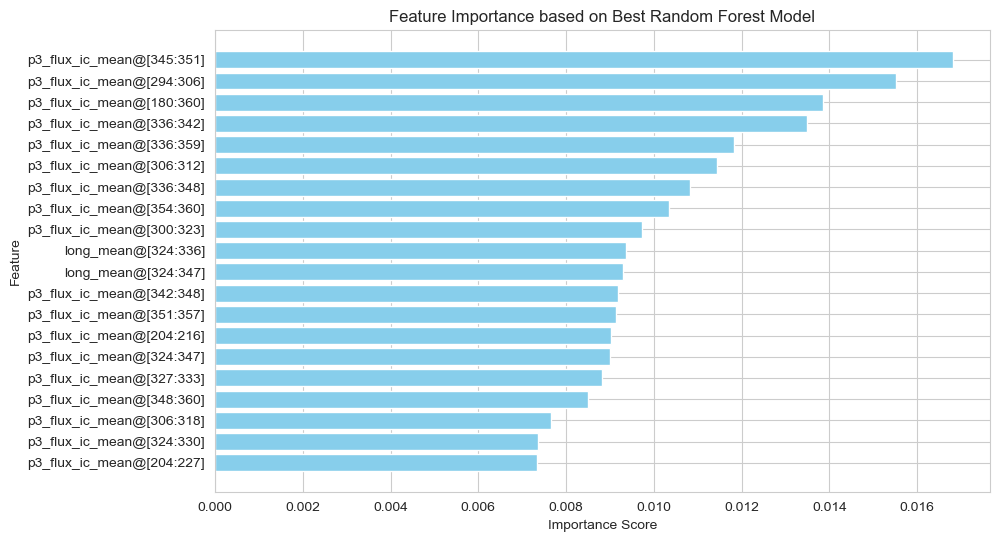

In [21]:
# Assuming `best_rf` is your trained Random Forest model
# and `X_train` contains the feature names

# Get feature importance scores
feature_importances = best_rf.feature_importances_

# Create a DataFrame to organize feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Display the top features
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance based on Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


In [22]:
 wandb.log({"feature_importance_plot": wandb.Image(plt)})

<Figure size 640x480 with 0 Axes>

Creating DiCE Counterfactual Explainers for SEP Prediction

In [23]:
df_cfe = df_test.drop(["Label"],axis=1)

#df_cfe = df_combined_labels.drop(["Label","File","Label.1"],axis=1)  # should contain the target column
cont_features = list(df_combined_labels.drop(["Label","Event_Y_N","File","Multi_Label"],axis=1).columns) #should not contain target column
data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name='Event_Y_N')

In [24]:
#Define a Model object using dice_ml.Model (we are using this CFE model for regressor type of prediction model
cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')
#Create the Dice explainer
exp_random = dice_ml.Dice(data_interface=data, model_interface=cfe_model, method="random") #method= ["genetic","kdtree","random"]

# Save the explainer (DiCE model) using joblib
joblib.dump(exp_random, "../models/sep_cfe_random_explainer.pkl")

#use `exp` to generate counterfactual explanations
print("\nRandom Dice explainer created successfully.\n")


Random Dice explainer created successfully.



In [25]:
# Log the model as an artifact in W&B
artifact = wandb.Artifact(name='DiCE_Explainer-Random_Method', type='model')
artifact.add_file("../models/sep_cfe_random_explainer.pkl")
wandb.log_artifact(artifact)

<Artifact DiCE_Explainer-Random_Method>

In [26]:
#Define a Model object using dice_ml.Model (we are using this CFE model for regressor type of prediction model
cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')
#Create the Dice explainer
exp_genetic = dice_ml.Dice(data_interface=data, model_interface=cfe_model, method="genetic") #method= ["genetic","kdtree","random"]

# Save the explainer (DiCE model) using joblib
joblib.dump(exp_genetic, "../models/sep_cfe_genetic_explainer.pkl")

#use `exp` to generate counterfactual explanations
print("\nGenetic Dice explainer created successfully.\n")


Genetic Dice explainer created successfully.



In [27]:
# Log the model as an artifact in W&B
artifact = wandb.Artifact(name='DiCE_Explainer-Genetic_Method', type='model')
artifact.add_file("../models/sep_cfe_genetic_explainer.pkl")
wandb.log_artifact(artifact)

<Artifact DiCE_Explainer-Genetic_Method>

In [28]:
wandb.finish()

Accuracy on Training Dataset,▁
Accuracy on Validation Dataset,▁
HSS on Training Dataset,▁
HSS on Validation Dataset,▁
TSS on Training Dataset,▁
TSS on Validation Dataset,▁
Accuracy on Training Dataset,0.95281
Accuracy on Validation Dataset,0.87988
HSS on Training Dataset,0.81608
HSS on Validation Dataset,0.4339
TSS on Training Dataset,0.80092
